In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import bisect
from scipy import spatial

We start by creating $n$ agents which are in $\mathbb{R}^p$. These agents are split in two groups, some of them are labelled $y=1$ and others $y=2$.

In [3]:
n, p = 200, 2 # number of agents, dimension
n1 = int(3*n/4)
n2 = n-n1
t, R = 2*np.pi*np.random.randn(n1,1), 3
r = R*(1.5 + .2*np.random.randn(n1,1)) # radius
X1 = np.hstack((np.cos(t)*r, np.sin(t)*r));
X = np.vstack((X1, np.random.randn(n2,2)))
y = np.vstack(( np.ones([n1,1]), 2*np.ones([n2,1]) ))

We plot the agents. Those in blue are labelled $y=1$ and in orange are labelled $y=2$.

(-5.914137948582541, 5.843744481955645, -6.028493149993848, 5.569680487903251)

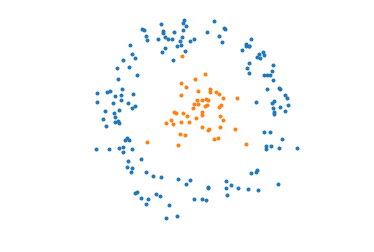

In [4]:
I = np.nonzero(y==1)[0]
J = np.nonzero(y==2)[0]
plt.plot(X[I,0], X[I,1], '.')
plt.plot(X[J,0], X[J,1], '.')
plt.axis('equal')
plt.axis('off')

The following function generate specific datas for each agent. Depending on their labelled and $\|x\|_2$, each agent received data from different distributions.

In [5]:
def create_data(x, y ,nsamples=1000):
    if y==1:
        data = np.random.poisson(np.linalg.norm(x), nsamples)
    elif y==2:
        data = ss.expon.rvs(np.linalg.norm(x), size=nsamples)
    else:
        print("choose y in {1,2}")
    return data

We define DATA to be list of data received by each agent. Then, we plot two examples :

In [63]:
DATA = [create_data(X[k], y[k], nsamples=10000) for k in range(n)]

i, j = np.random.choice(I), np.random.choice(J)
print('i=', i, 'et j=', j)
print('data for an element of I : ', DATA[i][:10])
print('data for an element of J : ', DATA[j][:10])

i= 143 et j= 165
data for an element of I :  [4 8 7 3 5 8 0 4 3 1]
data for an element of J :  [3.0808351  1.06146583 1.25370436 5.16521307 1.0998726  3.05515927
 1.44236694 2.70162648 2.30683153 1.04353693]


We build the similarity matrix.

In [36]:
def distmat(X, Z):
    return spatial.distance.cdist(X,Z)**2

def W(X,sigma):
    similarities = np.exp( -distmat(X,X)/(2*sigma**2) )
    np.fill_diagonal(similarities, 0)
    return similarities

We look the similarity matrix thanks to the functions defines above.

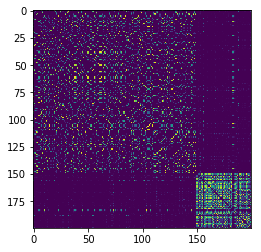

In [47]:
sigma = 1
K = W(X,sigma)
plt.imshow(K)

Now, we define two methods to calculate density functions from datas :

In [16]:
def methode_Noyau(data, K=ss.norm.pdf):
    nsamples = len(data)
    sigma = data.std()
    h = sigma/nsamples**(0.2) # thumb rule
    densite = lambda y : np.sum([K((y-x)/h) for x in data])/(nsamples*h)
    return densite

def methode_MC(data):
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob =  Nb_occurences/np.sum(Nb_occurences)
    return ensemble_des_valeurs, prob

We plot the density got from an agent labelled $y=1$.

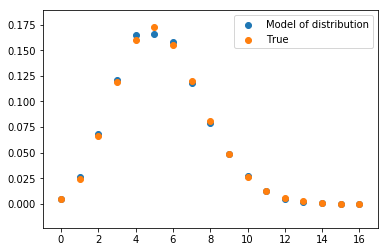

In [59]:
data = DATA[i]
ensemble_des_valeurs, prob = methode_MC(data)
plt.scatter(ensemble_des_valeurs, prob, label='Model of distribution')
plt.scatter(ensemble_des_valeurs, ss.poisson.pmf(ensemble_des_valeurs,np.linalg.norm(X[i])), label='True')
plt.legend()

We plot the density got from an agent labelled $y=2$.

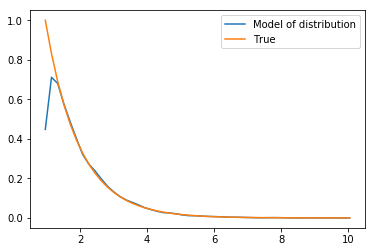

In [64]:
data = DATA[j]
densite = methode_Noyau(data)
tt = np.linspace(np.min(data), np.max(data), 50)
plt.plot(tt, [densite(t) for t in tt], label='Model of distribution')
plt.plot(tt, ss.expon.pdf(tt,np.linalg.norm(X[j])), label='True')
plt.legend()

Once we have the densities, we need the functions $g_s(v)$. Firstly, we define the cumulative empirical function $F$, and then $g$ represents its inverse. 

In [18]:
def F(data):
    nsamples = len(data)
    data_sorted = np.sort(data)
    return lambda t : bisect.bisect(data_sorted,t)/nsamples

def g(data):
    nsamples = len(data)
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob_cum = np.cumsum(Nb_occurences)/nsamples
    return prob_cum, ensemble_des_valeurs

For $u,v$ two neighbors, we plot $g_s(u)$ and $g_s(v)$ :

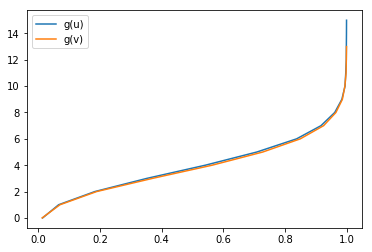

In [62]:
G = [g(data) for data in DATA]
u = np.random.randint(n)
v = np.argmax(K[u])

xx, yy = G[u]
plt.plot(xx, yy, label='g(u)')
xx, yy = G[v]
plt.plot(xx, yy, label='g(v)')
plt.legend()

We find that neighbor agents have very similar distributions. In conclusion, they can exchange information to better learn their models.